### Binary Classification Model for In-Vehicle Coupon Recommendation Using TensorFlow Decision Forests
### David Lowe
### December 14, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The In-Vehicle Coupon Recommendation dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: This dataset, available from UC Irvine's Machine Learning Repository, studies whether a person will accept the coupon recommended to him under different driving scenarios.

ANALYSIS: The performance of the preliminary Gradient Boosted Trees model achieved an accuracy benchmark of 0.7678 on the validation dataset. The final model processed the training dataset with an accuracy score of 0.7368. When we applied the finalized model to the validation dataset, the model achieved an accuracy score of 0.7678.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground 2021 November Data Set

Dataset Used: In-Vehicle Coupon Recommendation Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://archive-beta.ics.uci.edu/ml/datasets/in+vehicle+coupon+recommendation

## Task 1 - Prepare Environment

In [1]:
!pip install wurlitzer

In [2]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [3]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [4]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
import boto3
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
import tensorflow_decision_forests as tfdf

2021-12-13 16:58:16.634442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-13 16:58:16.634514: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.AUC()]

# Define the directory locations and file names
TRAIN_DATASET = 'in-vehicle-coupon-recommendation.csv'
# TEST_DATASET = 'test.csv'

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.7.0
Found TensorFlow Decision Forests v0.2.1


2021-12-13 16:58:20.879758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-13 16:58:20.879830: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-13 16:58:20.879901: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (91952dc61d28): /proc/driver/nvidia/version does not exist


In [7]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [8]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/ucirvine-in-vehicle-coupon-recommendation/in-vehicle-coupon-recommendation.csv

In [11]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

       destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never       NaN                  4~8           

In [12]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [13]:
print(df_dataset_import.describe())

        temperature  has_children  toCoupon_GEQ5min  toCoupon_GEQ15min  \
count  12684.000000  12684.000000           12684.0       12684.000000   
mean      63.301798      0.414144               1.0           0.561495   
std       19.154486      0.492593               0.0           0.496224   
min       30.000000      0.000000               1.0           0.000000   
25%       55.000000      0.000000               1.0           0.000000   
50%       80.000000      0.000000               1.0           1.000000   
75%       80.000000      1.000000               1.0           1.000000   
max       80.000000      1.000000               1.0           1.000000   

       toCoupon_GEQ25min  direction_same  direction_opp             Y  
count       12684.000000    12684.000000   12684.000000  12684.000000  
mean            0.119126        0.214759       0.785241      0.568433  
std             0.323950        0.410671       0.410671      0.495314  
min             0.000000        0.000000     

In [14]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64
Total number of NaN in the dataframe:  13370


### 1.d) Data Cleaning

In [15]:
# Dropping features that have too many NA's or have no variation
df_dataset_import.drop(columns=['car','toCoupon_GEQ5min','direction_opp'], inplace=True)

# Standardize the class column to the name of target
df_dataset_import = df_dataset_import.rename(columns={'Y':'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

       destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

            income    Bar CoffeeHouse CarryAway RestaurantLessThan20  \
0  $37500 - $49999  never       never       NaN                  4~8   
1  $37500 - $49999  never       never       

In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

In [17]:
print(df_dataset_import.describe())

        temperature  has_children  toCoupon_GEQ15min  toCoupon_GEQ25min  \
count  12684.000000  12684.000000       12684.000000       12684.000000   
mean      63.301798      0.414144           0.561495           0.119126   
std       19.154486      0.492593           0.496224           0.323950   
min       30.000000      0.000000           0.000000           0.000000   
25%       55.000000      0.000000           0.000000           0.000000   
50%       80.000000      0.000000           1.000000           0.000000   
75%       80.000000      1.000000           1.000000           0.000000   
max       80.000000      1.000000           1.000000           1.000000   

       direction_same        target  
count    12684.000000  12684.000000  
mean         0.214759      0.568433  
std          0.410671      0.495314  
min          0.000000      0.000000  
25%          0.000000      0.000000  
50%          0.000000      1.000000  
75%          0.000000      1.000000  
max          1.00000

In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               151
RestaurantLessThan20    130
Restaurant20To50        189
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
target                    0
dtype: int64
Total number of NaN in the dataframe:  794


### 1.e) Splitting Data into Sets

In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (12684, 23) df_features_import.shape: (12684, 22) df_target_import.shape: (12684,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

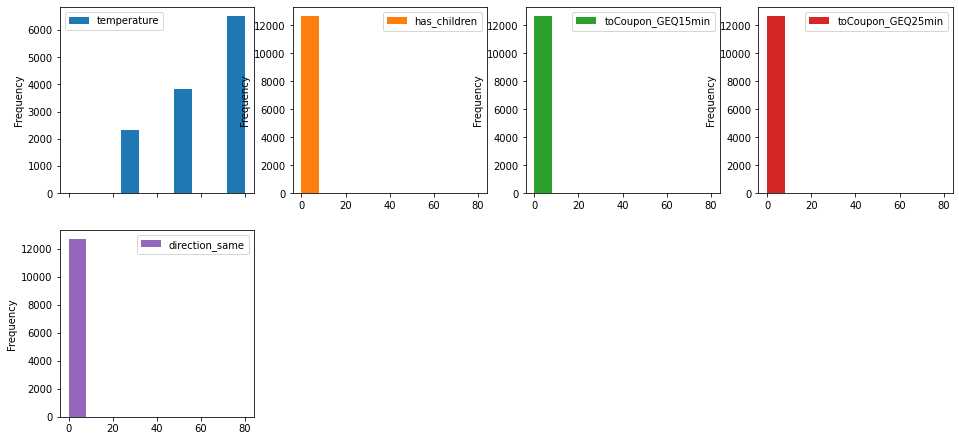

In [23]:
# Histograms for each attribute
df_features_import.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

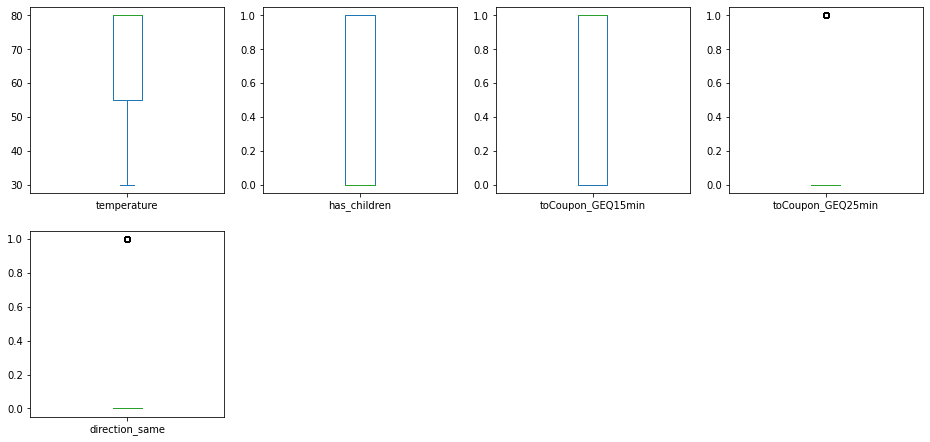

In [24]:
# Box and Whisker plot for each attribute
df_features_import.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

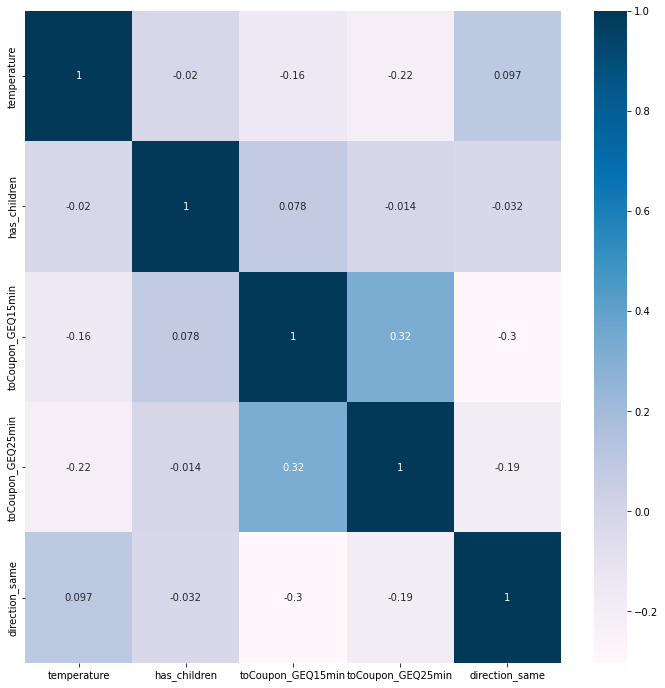

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(12, 12))
correlations = df_features_import.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [28]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (10147, 23) df_dataset_valid.shape: (2537, 23)


In [29]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task=tfdf.keras.Task.CLASSIFICATION)
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target', task=tfdf.keras.Task.CLASSIFICATION)

/home/pythonml/appdev/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [30]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("TFDF Random Forest modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
model_1 = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_1.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_1.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')
if NOTIFY_STATUS: status_notify("TFDF Random Forest modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

157/159 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 159
[INFO kernel.cc:393] Number of examples: 10147
[INFO kernel.cc:759] Dataset:
Number of records: 10147
Number of columns: 23

Number of columns by type:
	CATEGORICAL: 18 (78.2609%)
	NUMERICAL: 5 (21.7391%)

Columns:

CATEGORICAL: 18 (78.2609%)
	0: "Bar" CATEGORICAL num-nas:80 (0.78841%) has-dict vocab-size:6 zero-ood-items most-frequent:"never" 4181 (41.5317%)
	1: "CarryAway" CATEGORICAL num-nas:115 (1.13334%) has-dict vocab-size:6 zero-ood-items most-frequent:"1~3" 3711 (36.9916%)
	2: "CoffeeHouse" CATEGORICAL num-nas:161 (1.58668%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 2720 (27.2381%)
	3: "Restaurant20To50" CATEGORICAL num-nas:154 (1.51769%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 4886 (48.8942%)
	4: "RestaurantLessThan20" CATEGORICAL num-nas:100 (0.985513%) has-dict vocab-size:6 zero-ood-items most-frequ

159/159 [==============================] - 34s 106ms/step
Model training time: 0:00:45.437209 



In [31]:
# tfdf.model_plotter.plot_model_in_colab(model_1)

In [32]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=10147, accuracy=0.7559869912289346, loss=0.5059480755366411, rmse=None, ndcg=None, aucs=None)

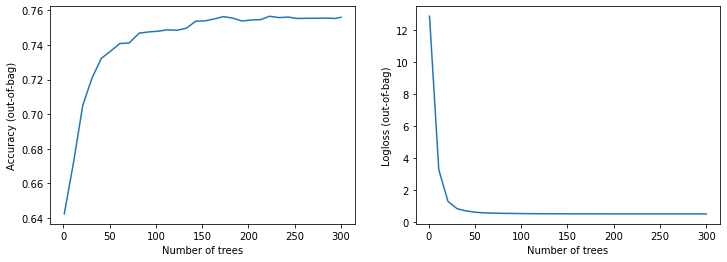

In [33]:
logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [34]:
evaluation = model_1.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

40/40 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - accuracy: 0.7592 - auc: 0.8395

loss: 0.0000
accuracy: 0.7592
auc: 0.8395


### 3.c) Train and Evaluate the Decision Trees Model

In [35]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("TFDF Decision Trees modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
model_2 = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_2.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_2.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')
if NOTIFY_STATUS: status_notify("TFDF Decision Trees modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

154/159 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 159
[INFO kernel.cc:393] Number of examples: 10147
[INFO kernel.cc:759] Dataset:
Number of records: 10147
Number of columns: 23

Number of columns by type:
	CATEGORICAL: 18 (78.2609%)
	NUMERICAL: 5 (21.7391%)

Columns:

CATEGORICAL: 18 (78.2609%)
	0: "Bar" CATEGORICAL num-nas:80 (0.78841%) has-dict vocab-size:6 zero-ood-items most-frequent:"never" 4181 (41.5317%)
	1: "CarryAway" CATEGORICAL num-nas:115 (1.13334%) has-dict vocab-size:6 zero-ood-items most-frequent:"1~3" 3711 (36.9916%)
	2: "CoffeeHouse" CATEGORICAL num-nas:161 (1.58668%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 2720 (27.2381%)
	3: "Restaurant20To50" CATEGORICAL num-nas:154 (1.51769%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 4886 (48.8942%)
	4: "RestaurantLessThan20" CATEGORICAL num-nas:100 (0.985513%) has-dict vocab-size:6 zero-ood-items most-frequ

159/159 [==============================] - 2s 9ms/step
Model training time: 0:00:02.837613 



In [36]:
# tfdf.model_plotter.plot_model_in_colab(model_2)

In [37]:
model_2.make_inspector().evaluation()

In [38]:
evaluation = model_2.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

40/40 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.6969 - auc: 0.7841

loss: 0.0000
accuracy: 0.6969
auc: 0.7841


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [39]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("TFDF Gradient Boosted Treees modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
model_3 = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
model_3.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    model_3.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')
if NOTIFY_STATUS: status_notify("TFDF Gradient Boosted Trees modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

156/159 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 159
[INFO kernel.cc:393] Number of examples: 10147
[INFO kernel.cc:759] Dataset:
Number of records: 10147
Number of columns: 23

Number of columns by type:
	CATEGORICAL: 18 (78.2609%)
	NUMERICAL: 5 (21.7391%)

Columns:

CATEGORICAL: 18 (78.2609%)
	0: "Bar" CATEGORICAL num-nas:80 (0.78841%) has-dict vocab-size:6 zero-ood-items most-frequent:"never" 4181 (41.5317%)
	1: "CarryAway" CATEGORICAL num-nas:115 (1.13334%) has-dict vocab-size:6 zero-ood-items most-frequent:"1~3" 3711 (36.9916%)
	2: "CoffeeHouse" CATEGORICAL num-nas:161 (1.58668%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 2720 (27.2381%)
	3: "Restaurant20To50" CATEGORICAL num-nas:154 (1.51769%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 4886 (48.8942%)
	4: "RestaurantLessThan20" CATEGORICAL num-nas:100 (0.985513%) has-dict vocab-size:6 zero-ood-items most-frequ

159/159 [==============================] - 7s 42ms/step
Model training time: 0:00:08.104012 



In [40]:
# tfdf.model_plotter.plot_model_in_colab(model_3)

In [41]:
model_3.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.7368420958518982, loss=1.0229867696762085, rmse=None, ndcg=None, aucs=None)

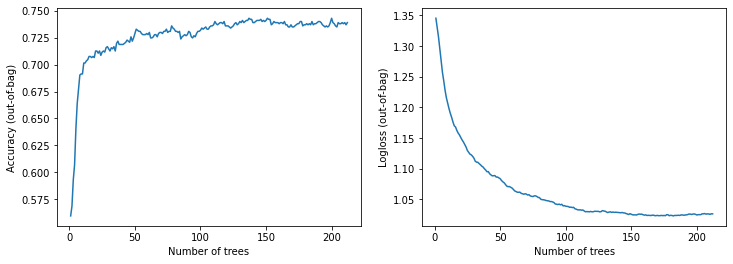

In [42]:
logs = model_3.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [43]:
evaluation = model_3.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

40/40 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 0.7678 - auc: 0.8019

loss: 0.0000
accuracy: 0.7678
auc: 0.8019


In [44]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [46]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    print('Modeling with the num_trees parameter set to', num_trees)
    model_tune = tfdf.keras.GradientBoostedTreesModel(num_trees=num_trees, task=tfdf.keras.Task.CLASSIFICATION)

    # Optionally, add evaluation metrics.
    model_tune.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    model_tune.fit(x=tfds_train, verbose=False)
    print()

#     evaluation = model_tune.evaluate(tfds_valid, return_dict=True)
#     print()

#     for name, value in evaluation.items():
#         print(f"{name}: {value:.4f}")
#     print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

Modeling with the num_trees parameter set to 300


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 159
[INFO kernel.cc:393] Number of examples: 10147
[INFO kernel.cc:759] Dataset:
Number of records: 10147
Number of columns: 23

Number of columns by type:
	CATEGORICAL: 18 (78.2609%)
	NUMERICAL: 5 (21.7391%)

Columns:

CATEGORICAL: 18 (78.2609%)
	0: "Bar" CATEGORICAL num-nas:80 (0.78841%) has-dict vocab-size:6 zero-ood-items most-frequent:"never" 4181 (41.5317%)
	1: "CarryAway" CATEGORICAL num-nas:115 (1.13334%) has-dict vocab-size:6 zero-ood-items most-frequent:"1~3" 3711 (36.9916%)
	2: "CoffeeHouse" CATEGORICAL num-nas:161 (1.58668%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 2720 (27.2381%)
	3: "Restaurant20To50" CATEGORICAL num-nas:154 (1.51769%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 4886 (48.8942%)
	4: "RestaurantLessThan20" CATEGORICAL num-nas:100 (0.985513%) has-dict vocab-size:6 zero-ood-items most-frequ


Modeling with the num_trees parameter set to 500


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 159
[INFO kernel.cc:393] Number of examples: 10147
[INFO kernel.cc:759] Dataset:
Number of records: 10147
Number of columns: 23

Number of columns by type:
	CATEGORICAL: 18 (78.2609%)
	NUMERICAL: 5 (21.7391%)

Columns:

CATEGORICAL: 18 (78.2609%)
	0: "Bar" CATEGORICAL num-nas:80 (0.78841%) has-dict vocab-size:6 zero-ood-items most-frequent:"never" 4181 (41.5317%)
	1: "CarryAway" CATEGORICAL num-nas:115 (1.13334%) has-dict vocab-size:6 zero-ood-items most-frequent:"1~3" 3711 (36.9916%)
	2: "CoffeeHouse" CATEGORICAL num-nas:161 (1.58668%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 2720 (27.2381%)
	3: "Restaurant20To50" CATEGORICAL num-nas:154 (1.51769%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 4886 (48.8942%)
	4: "RestaurantLessThan20" CATEGORICAL num-nas:100 (0.985513%) has-dict vocab-size:6 zero-ood-items most-frequ

[INFO kernel.cc:848] Use fast generic engine



Modeling with the num_trees parameter set to 750


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 159
[INFO kernel.cc:393] Number of examples: 10147
[INFO kernel.cc:759] Dataset:
Number of records: 10147
Number of columns: 23

Number of columns by type:
	CATEGORICAL: 18 (78.2609%)
	NUMERICAL: 5 (21.7391%)

Columns:

CATEGORICAL: 18 (78.2609%)
	0: "Bar" CATEGORICAL num-nas:80 (0.78841%) has-dict vocab-size:6 zero-ood-items most-frequent:"never" 4181 (41.5317%)
	1: "CarryAway" CATEGORICAL num-nas:115 (1.13334%) has-dict vocab-size:6 zero-ood-items most-frequent:"1~3" 3711 (36.9916%)
	2: "CoffeeHouse" CATEGORICAL num-nas:161 (1.58668%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 2720 (27.2381%)
	3: "Restaurant20To50" CATEGORICAL num-nas:154 (1.51769%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 4886 (48.8942%)
	4: "RestaurantLessThan20" CATEGORICAL num-nas:100 (0.985513%) has-dict vocab-size:6 zero-ood-items most-frequ


Modeling with the num_trees parameter set to 1000


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 159
[INFO kernel.cc:393] Number of examples: 10147
[INFO kernel.cc:759] Dataset:
Number of records: 10147
Number of columns: 23

Number of columns by type:
	CATEGORICAL: 18 (78.2609%)
	NUMERICAL: 5 (21.7391%)

Columns:

CATEGORICAL: 18 (78.2609%)
	0: "Bar" CATEGORICAL num-nas:80 (0.78841%) has-dict vocab-size:6 zero-ood-items most-frequent:"never" 4181 (41.5317%)
	1: "CarryAway" CATEGORICAL num-nas:115 (1.13334%) has-dict vocab-size:6 zero-ood-items most-frequent:"1~3" 3711 (36.9916%)
	2: "CoffeeHouse" CATEGORICAL num-nas:161 (1.58668%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 2720 (27.2381%)
	3: "Restaurant20To50" CATEGORICAL num-nas:154 (1.51769%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 4886 (48.8942%)
	4: "RestaurantLessThan20" CATEGORICAL num-nas:100 (0.985513%) has-dict vocab-size:6 zero-ood-items most-frequ

In [47]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [48]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [49]:
# Finalize the training and validation datasets for the modeling activities
# tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_import, label='target')

In [50]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("The final TFDF model training has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
final_model = tfdf.keras.GradientBoostedTreesModel(num_trees=1000, task=tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
final_model.compile(metrics=DEFAULT_METRICS)

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
    final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')
if NOTIFY_STATUS: status_notify("The final TFDF model training completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

154/159 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 159
[INFO kernel.cc:393] Number of examples: 10147
[INFO kernel.cc:759] Dataset:
Number of records: 10147
Number of columns: 23

Number of columns by type:
	CATEGORICAL: 18 (78.2609%)
	NUMERICAL: 5 (21.7391%)

Columns:

CATEGORICAL: 18 (78.2609%)
	0: "Bar" CATEGORICAL num-nas:80 (0.78841%) has-dict vocab-size:6 zero-ood-items most-frequent:"never" 4181 (41.5317%)
	1: "CarryAway" CATEGORICAL num-nas:115 (1.13334%) has-dict vocab-size:6 zero-ood-items most-frequent:"1~3" 3711 (36.9916%)
	2: "CoffeeHouse" CATEGORICAL num-nas:161 (1.58668%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 2720 (27.2381%)
	3: "Restaurant20To50" CATEGORICAL num-nas:154 (1.51769%) has-dict vocab-size:6 zero-ood-items most-frequent:"less1" 4886 (48.8942%)
	4: "RestaurantLessThan20" CATEGORICAL num-nas:100 (0.985513%) has-dict vocab-size:6 zero-ood-items most-frequ

159/159 [==============================] - 7s 42ms/step
Model training time: 0:00:08.038006 



In [51]:
final_model.summary()

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (22):
	Bar
	CarryAway
	CoffeeHouse
	Restaurant20To50
	RestaurantLessThan20
	age
	coupon
	destination
	direction_same
	education
	expiration
	gender
	has_children
	income
	maritalStatus
	occupation
	passanger
	temperature
	time
	toCoupon_GEQ15min
	toCoupon_GEQ25min
	weather

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.              "__LABEL"  4.982387 ################
    2.         "has_children"  4.850582 ##############
    3.    "toCoupon_GEQ25min"  4.828789 ##############
    4.               "gender"  4.716585 #############
    5.          "temperature"  4.708634 #############
    6.        "mar

In [52]:
# tfdf.model_plotter.plot_model_in_colab(final_model)

In [53]:
final_model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=0.7368420958518982, loss=1.0229867696762085, rmse=None, ndcg=None, aucs=None)

### 5.b) Load Test Dataset and Make Predictions

In [54]:
evaluation = final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

40/40 [==============================] - 1s 10ms/step - loss: 0.0000e+00 - accuracy: 0.7678 - auc: 0.8107

loss: 0.0000
accuracy: 0.7678
auc: 0.8107


In [55]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [56]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:01:55.542487
